In [32]:
import pandas as pd
pd.set_option('display.max_columns', 50) 
import numpy as np
import datetime
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['KaiTi']  # 显示中文
plt.rcParams['axes.unicode_minus'] = False
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname=r"c:\windows\fonts\simhei.ttf", size=14)

import chinese_calendar as calendar

In [2]:
from sklearn.model_selection import cross_val_predict, RandomizedSearchCV ##对数据集进行指定次数的交叉验证并为每次验证效果评测
import lightgbm as lgb ##lightGBM模型
from lightgbm import LGBMRegressor
from sklearn.model_selection import StratifiedKFold, KFold ##交叉验证
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score  #平方绝对误差，均方误差， #R square
from sklearn.model_selection import train_test_split 
import joblib
import math
from sklearn.model_selection import cross_val_score

In [3]:
data=pd.read_excel('模型数据/2018年数据20200803.xlsx')
data.head()

,就诊时间,年龄,性别,分诊科室,分诊等级,分诊去向,分诊时间,到诊时间,抢救上床时间,体温类型,体温,脉搏,收缩压,舒张压,呼吸,SpO2,微量血糖,疼痛评分,GCS评分,PHI评分,来诊主诉,主诉,现病史,既病史,药物过敏史,诊断,处理意见,注意事项,时长,没有时长的主诉,时长（统一数字）_1,编码,分诊,到诊,时间差,分诊-年,分诊-月,分诊-日,分诊-时,分诊-分,分诊-秒,候诊/分钟
0,2017-12-31 23:59:00,59.0,男,急诊外科,2,医疗室,2018-01-01 00:01:00,2018-01-01 01:37:00,,耳温,37.0,51.00,181.000,59.00,19.3,99.0,0.0,43289,15,0,腰痛伴呕吐3小时余,腰背部疼痛3小时,腰背部疼痛3小时，进食后出现腰背痛，伴恶心呕吐，活动可,高血压病,否认,腰痛查因,治疗 静脉采血成组(含一次性采血针) 检验 血常规五分类(末梢...,注意休息，如有不适，请及时就诊。,['3小时余'],腰痛伴呕吐,['3时'],"[60315, 70101, 0, 0]",2018-01-01 00:01:00,2018-01-01 01:37:00,0.066667,2018,1,1,0,1,0,96
1,2018-01-01 00:14:00,41.0,男,急诊内科,4,医疗室,2018-01-01 00:20:00,2018-01-01 08:15:00,,耳温,37.0,100.00,128.000,85.00,20.0,98.0,0.0,,15,0,咽部不适,,,,,,,,[],咽部不适,[''],"[60105, 0, 0, 0]",2018-01-01 00:20:00,2018-01-01 08:15:00,0.329861,2018,1,1,0,20,0,475
2,2018-01-01 00:19:00,59.0,女,急诊内科,3,医疗室,2018-01-01 00:24:00,2018-01-01 02:42:00,2018-01-01 03:05:00,耳温,36.0,74.00,168.000,85.00,20.0,99.0,0.0,,15,0,自诉咽痛鼻塞声嘶7天伴胸部不适1小时,心悸、胸闷3小时,患者于3小时因心悸、胸闷，无胸痛，伴头晕，耳鸣，无伴呕吐，无伴咳嗽、咳痰，无发热，无排黑便。,无“高血压”有“糖尿病”。,未发现,胸闷查因,处方 0.9%氯化钠注射液 1袋 250ML IVD 每日一次 ...,II级护理;测BP P SpO2 q2H；留陪人;,"['7天', '1小时']",自诉咽痛鼻塞声嘶伴胸部不适,['1时'],"[100104, 30303, 100105, 60105]",2018-01-01 00:24:00,2018-01-01 02:42:00,0.095833,2018,1,1,0,24,0,138
3,2018-01-01 00:30:00,1.0,女,急诊儿科,3,医疗室,2018-01-01 00:32:00,2018-01-01 01:41:00,,耳温,38.9,89.96,138.404,81.03,19.3,0.0,0.0,,15,0,发热半天,,,,,,,,['半天'],发热,['半天'],"[110121, 0, 0, 0]",2018-01-01 00:32:00,2018-01-01 01:41:00,0.047917,2018,1,1,0,32,0,69
4,2018-01-01 00:33:00,14.0,男,急诊儿科,3,医疗室,2018-01-01 00:34:00,2018-01-01 01:44:00,,耳温,39.0,89.96,138.404,81.03,19.3,0.0,0.0,,15,0,发热伴出水痘1天,,,,,,,,['1天'],发热伴出水痘,['1天'],"[90130, 110121, 0, 0]",2018-01-01 00:34:00,2018-01-01 01:44:00,0.048611,2018,1,1,0,34,0,70


In [4]:
# data['主诉1']=data['编码'].apply(lambda x:eval(x)[0])
data['主诉2']=data['编码'].apply(lambda x:eval(x)[1])
data['主诉3']=data['编码'].apply(lambda x:eval(x)[2])
data['主诉4']=data['编码'].apply(lambda x:eval(x)[3])

In [5]:
data=data[[ '年龄', '性别', '分诊科室', '分诊等级', '分诊去向', '分诊时间', '到诊时间',
       '体温类型', '体温', '脉搏', '收缩压', '舒张压', '呼吸', 'SpO2', '微量血糖', 'GCS评分',
       'PHI评分', '编码', '分诊', '到诊', '时间差', '分诊-年', '分诊-月',
       '分诊-日', '分诊-时', '分诊-分', '分诊-秒', '候诊/分钟']]
data.head()

,年龄,性别,分诊科室,分诊等级,分诊去向,分诊时间,到诊时间,体温类型,体温,脉搏,收缩压,舒张压,呼吸,SpO2,微量血糖,GCS评分,PHI评分,编码,分诊,到诊,时间差,分诊-年,分诊-月,分诊-日,分诊-时,分诊-分,分诊-秒,候诊/分钟
0,59.0,男,急诊外科,2,医疗室,2018-01-01 00:01:00,2018-01-01 01:37:00,耳温,37.0,51.00,181.000,59.00,19.3,99.0,0.0,15,0,"[60315, 70101, 0, 0]",2018-01-01 00:01:00,2018-01-01 01:37:00,0.066667,2018,1,1,0,1,0,96
1,41.0,男,急诊内科,4,医疗室,2018-01-01 00:20:00,2018-01-01 08:15:00,耳温,37.0,100.00,128.000,85.00,20.0,98.0,0.0,15,0,"[60105, 0, 0, 0]",2018-01-01 00:20:00,2018-01-01 08:15:00,0.329861,2018,1,1,0,20,0,475
2,59.0,女,急诊内科,3,医疗室,2018-01-01 00:24:00,2018-01-01 02:42:00,耳温,36.0,74.00,168.000,85.00,20.0,99.0,0.0,15,0,"[100104, 30303, 100105, 60105]",2018-01-01 00:24:00,2018-01-01 02:42:00,0.095833,2018,1,1,0,24,0,138
3,1.0,女,急诊儿科,3,医疗室,2018-01-01 00:32:00,2018-01-01 01:41:00,耳温,38.9,89.96,138.404,81.03,19.3,0.0,0.0,15,0,"[110121, 0, 0, 0]",2018-01-01 00:32:00,2018-01-01 01:41:00,0.047917,2018,1,1,0,32,0,69
4,14.0,男,急诊儿科,3,医疗室,2018-01-01 00:34:00,2018-01-01 01:44:00,耳温,39.0,89.96,138.404,81.03,19.3,0.0,0.0,15,0,"[90130, 110121, 0, 0]",2018-01-01 00:34:00,2018-01-01 01:44:00,0.048611,2018,1,1,0,34,0,70


# 模型组装-20200804

In [6]:
def model_fit(x_train, x_test, y_train, y_test):
    
    
    gbm = lgb.LGBMRegressor(n_estimators=2000,num_leaves=90,max_depth=13,early_stopping_round=50,metric=['l1'])
    gbm.fit(x_train,y_train,eval_set=[(x_train,y_train),(x_test,y_test)],eval_metric='l1',verbose=20)
    
    y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration_)

    print('================================================')
    print('平均绝对误差:', mean_absolute_error(y_test, y_pred))

    print('均方根误差：', mean_squared_error(y_test,y_pred))

    print('R方决定系数：' , r2_score(y_test,y_pred)  )
    ##决定系数：R2（R-Square）
    ##一般来说，R-Squared 越大，表示模型拟合效果越好。R-Squared 反映的是大概有多准，
    ##因为，随着样本数量的增加，R-Square必然增加，无法真正定量说明准确程度，只能大概定量。

    #     校正决定系数（Adjusted R-Square）=1-(1-r^2)*(n-1)/(n-p-1) 其中，n 是(测试集)样本数量，p 是特征数量。
    print('校正决定系数(Adjusted R-Square）：' , 1-((1-r2_score(y_test,y_pred))*(len(y_test)-1))/(len(x_test)-len(x_test.columns)-1) )
    print('===================================================')

    plt.figure(figsize=(13,7))

    plt.plot(np.array(y_test),'b.',label='y_test')
    plt.plot(np.array(y_pred),'r.',label='y_predict')

    plt.title('测试集')
    plt.legend(loc='center', bbox_to_anchor=(1.063,0.9),ncol=1) # 显示图例
    plt.show()
    return gbm,y_pred

# 特征处理-20200806 ：节假日、周末、工作日

In [7]:

#对性别的处理
male=['男','女']
data['性别']=data['性别'].map(dict(zip(male,range(0,len(male)+1))))

#对分诊科室的处理
fenzhen_department=['急诊外科', '急诊内科', '急诊儿科', '急诊产科', '内科夜诊', '发热门诊', '急诊耳鼻喉科', '急诊复诊',
       '急诊眼科', '急诊妇科', '急诊口腔科', '急诊感染科', '急诊新生儿科']
data['分诊科室']=data['分诊科室'].map(dict(zip(fenzhen_department,range(1,len(fenzhen_department)+1))))

#对分诊去向的处理
fenzhen_whereabouts=['医疗室', '抢救室']
data['分诊去向']=data['分诊去向'].map(dict(zip(fenzhen_whereabouts,range(1,len(fenzhen_whereabouts)+1))))
#对体温类型的处理
type_temperature=['耳温', '腋温']
data['体温类型']=data['体温类型'].map(dict(zip(type_temperature,range(1,len(type_temperature)+1))))
#添加特征‘脉压差’
data['脉压差']=data['收缩压']-data['舒张压']

In [8]:
#节假日
def get_holiday(year=2020,mon=10,day=1):
    ##判断节假日，区别休息日
    cet=calendar.get_holiday_detail(datetime.date(year,mon,day))
    if cet[0]==True:
        ##判断是否是休息日
        if cet[1]==None:
            #休息日
            return 2
        else:
            #节假日
            return 1
    return 0
data['节假日']=data.apply(lambda x:1 if get_holiday(x['分诊-年'],x['分诊-月'], x['分诊-日'])==1 else 0,axis=1)
data['休息日']=data.apply(lambda x:1 if get_holiday(x['分诊-年'],x['分诊-月'], x['分诊-日'])==2 else 0,axis=1)
data['工作日']=data.apply(lambda x:1 if calendar.is_workday(datetime.date(x['分诊-年'],x['分诊-月'], x['分诊-日'])) else 0,axis=1)

In [9]:
len(data[data['节假日']==1])

10187

In [10]:
len(data[data['休息日']==1])

36550

In [11]:
len(data[data['工作日']==1])

81908

In [12]:
len(data[data['工作日']==0])

46737

In [13]:
data['发病季节']=[0]*len(data)
for i in range(len(data)):
    if   3<=data['分诊-月'][i]<=5:
        data['发病季节'][i]='春'
    elif 6 <= data['分诊-月'][i]<= 8:
        data['发病季节'][i]='夏'
    elif 9 <= data['分诊-月'][i]<= 11:
        data['发病季节'][i]='秋'
    elif data['分诊-月'][i]==12 or data['分诊-月'][i]==1 or data['分诊-月'][i]==2:
        data['发病季节'][i]='冬'
seasion=['春','夏','秋', '冬']
data['发病季节']=data['发病季节'].map(dict(zip(seasion,range(1,len(seasion)+1))))

F:\Anaconda\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
F:\Anaconda\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
F:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
F

In [14]:
not_needcolumns=[ '分诊时间', '到诊时间','编码', '分诊', '到诊', '时间差', '分诊-年', '分诊-秒', '候诊/分钟','发病季节']
train_col = [i for i in data.columns if i not in not_needcolumns]
print(train_col)


['年龄', '性别', '分诊科室', '分诊等级', '分诊去向', '体温类型', '体温', '脉搏', '收缩压', '舒张压', '呼吸', 'SpO2', '微量血糖', 'GCS评分', 'PHI评分', '分诊-月', '分诊-日', '分诊-时', '分诊-分', '脉压差', '节假日', '休息日', '工作日']


F:\Anaconda\lib\site-packages\lightgbm\engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
[20]	training's l1: 23.3774	valid_1's l1: 24.0799
[40]	training's l1: 22.3235	valid_1's l1: 23.4107
[60]	training's l1: 21.8856	valid_1's l1: 23.3213
[80]	training's l1: 21.5696	valid_1's l1: 23.2388
[100]	training's l1: 21.2574	valid_1's l1: 23.1851
[120]	training's l1: 20.9646	valid_1's l1: 23.1476
[140]	training's l1: 20.784	valid_1's l1: 23.1358
[160]	training's l1: 20.6104	valid_1's l1: 23.1061
[180]	training's l1: 20.4358	valid_1's l1: 23.077
[200]	training's l1: 20.2256	valid_1's l1: 23.0297
[220]	training's l1: 20.0089	valid_1's l1: 22.9871
[240]	training's l1: 19.8234	valid_1's l1: 22.9433
[260]	training's l1: 19.6703	valid_1's l1: 22.923
[280]	training's l1: 19.5287	valid_1's l1: 22.9104
[300]	training's l1: 19.3976	valid_1's l1: 22.9091
[320]	training's l1: 19.2667	valid_1's l1: 22.9134
[340]	training's l1: 19.107	valid_1's l1: 22.8779
[360]	training's l1: 18.9173	valid_1's l1: 22.8091
[380]	training's l1: 18.7749

F:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
F:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


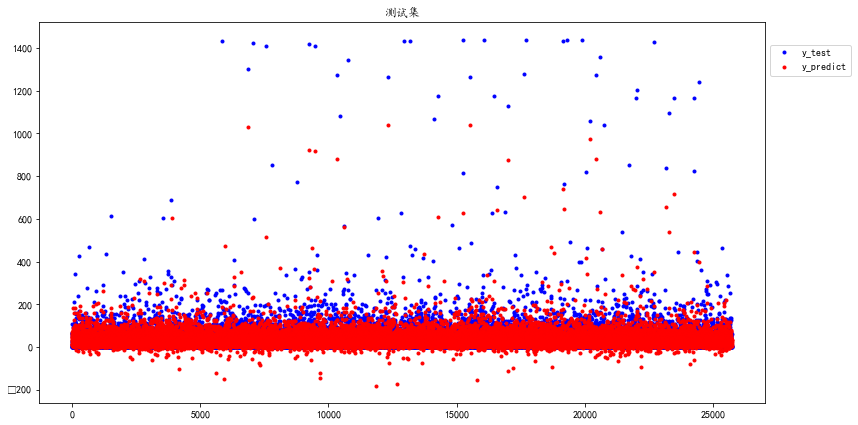

In [15]:
x_data=data[train_col].copy()
y_data=data['候诊/分钟'].copy()
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data,test_size=0.2, random_state=1)##test_size为测试集的占比
_,y_pre=model_fit(x_train, x_test, y_train, y_test)

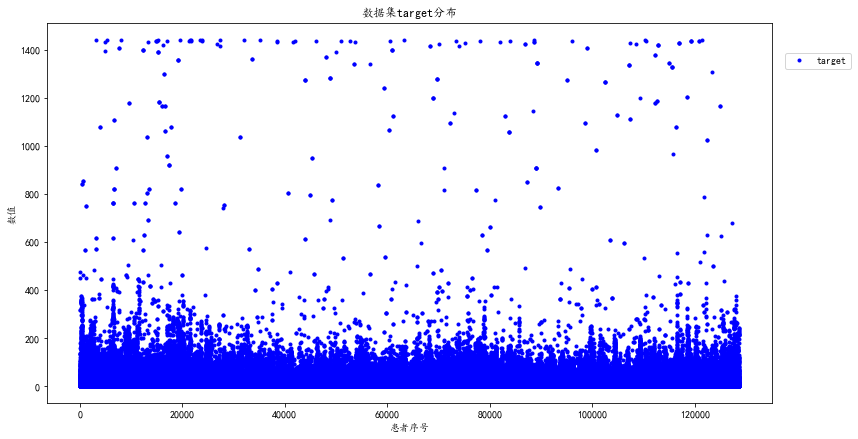

In [51]:
plt.figure(figsize=(13,7))

plt.plot(np.array(data['候诊/分钟']),'b.',label='target')
#设置出横坐标
plt.xlabel('患者序号')
#设置纵坐标的标题
plt.ylabel('数值')
#设置整个图片的标题
plt.title('数据集target分布')
plt.legend(loc='center', bbox_to_anchor=(1.063,0.9),ncol=1) # 显示图例
plt.show()

In [52]:
min(data['候诊/分钟'])

0

In [54]:
data['候诊/分钟'].describe()

count    128645.000000
mean         32.483898
std          66.320823
min           0.000000
25%           4.000000
50%          15.000000
75%          41.000000
max        1439.000000
Name: 候诊/分钟, dtype: float64

In [39]:
len(x_train[x_train['休息日']==1])

29174

In [40]:
len(x_test[x_test['休息日']==1])

7376

In [17]:
result=pd.DataFrame()
result['真实值']=y_test
result['预测值']=y_pre
result['预-真']=result['预测值']-result['真实值']

In [55]:
result[((result['预测值']-result['真实值'])<15) & ((result['预测值']-result['真实值'])>=-15)]

,真实值,预测值,预-真
65291,2,8.606007,6.606007
18826,62,59.553522,-2.446478
105519,14,14.321586,0.321586
103283,52,45.781401,-6.218599
119240,30,34.900385,4.900385
...,...,...,...
73157,0,9.214898,9.214898
11953,3,8.648669,5.648669
28310,70,68.830594,-1.169406
16170,1,3.056194,2.056194


In [21]:
len(result[result['预测值']<0])

511

In [44]:
max(result['预-真'])

552.7648608158094

In [45]:
min(result['预-真'])

-1425.9263032714762

In [46]:
result[result['预-真']<-1000]

,真实值,预测值,预-真
38394,1432,6.073697,-1425.926303
16264,1421,233.799799,-1187.200201
114940,1345,19.117624,-1325.882376
83913,1434,29.090630,-1404.909370
38507,1434,64.191646,-1369.808354
60273,1066,59.428821,-1006.571179
63215,1438,51.986481,-1386.013519
23512,1439,107.850085,-1331.149915
52661,1436,111.788167,-1324.211833
5303,1439,202.190676,-1236.809324


In [47]:
result[result['真实值']>1000]

,真实值,预测值,预-真
38394,1432,6.073697,-1425.926303
16337,1300,1030.269458,-269.730542
16264,1421,233.799799,-1187.200201
98912,1407,516.828552,-890.171448
112866,1417,920.941847,-496.058153
7629,1408,917.402436,-490.597564
43885,1274,878.331384,-395.668616
17721,1080,110.843836,-969.156164
114940,1345,19.117624,-1325.882376
102411,1264,1039.948675,-224.051325


In [56]:
14437/len(result)

0.561117804811691

In [25]:
list_yuce=result['预测值'].tolist()

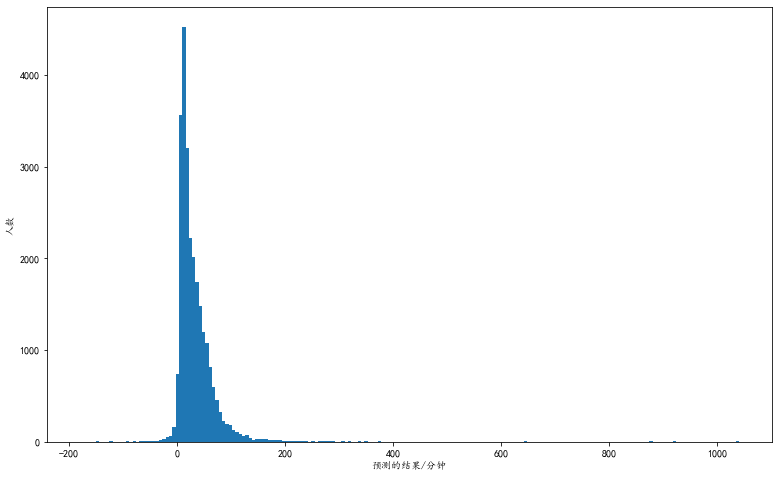

In [34]:
# 对数据进行切片，将数据按照从最小值到最大值分组，分成20组

bins = np.linspace(min(list_yuce),max(list_yuce),200)

fig = plt.figure(figsize=(13, 8))
plt.hist(list_yuce,bins)

#设置出横坐标
plt.xlabel('预测的结果/分钟')
#设置纵坐标的标题
plt.ylabel('人数')
#设置整个图片的标题
plt.title('')

# 展示出我们的图片
plt.show()

In [18]:
data.to_excel('源数据/test.xlsx')

# 特征工程-20200804

In [11]:

#对性别的处理
male=['男','女']
data['性别']=data['性别'].map(dict(zip(male,range(0,len(male)+1))))

#对分诊科室的处理
fenzhen_department=['急诊外科', '急诊内科', '急诊儿科', '急诊产科', '内科夜诊', '发热门诊', '急诊耳鼻喉科', '急诊复诊',
       '急诊眼科', '急诊妇科', '急诊口腔科', '急诊感染科', '急诊新生儿科']
data['分诊科室']=data['分诊科室'].map(dict(zip(fenzhen_department,range(1,len(fenzhen_department)+1))))

#对分诊去向的处理
fenzhen_whereabouts=['医疗室', '抢救室']
data['分诊去向']=data['分诊去向'].map(dict(zip(fenzhen_whereabouts,range(1,len(fenzhen_whereabouts)+1))))
#对体温类型的处理
type_temperature=['耳温', '腋温']
data['体温类型']=data['体温类型'].map(dict(zip(type_temperature,range(1,len(type_temperature)+1))))

In [12]:
data['脉压差']=data['收缩压']-data['舒张压']

In [13]:
not_needcolumns=[ '分诊时间', '到诊时间','编码', '分诊', '到诊', '时间差', '分诊-年', '分诊-秒', '候诊/分钟']
train_col = [i for i in data.columns if i not in not_needcolumns]
print(train_col)

['年龄', '性别', '分诊科室', '分诊等级', '分诊去向', '体温类型', '体温', '脉搏', '收缩压', '舒张压', '呼吸', 'SpO2', '微量血糖', 'GCS评分', 'PHI评分', '分诊-月', '分诊-日', '分诊-时', '分诊-分', '脉压差', '工作日']


F:\Anaconda\lib\site-packages\lightgbm\engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
[20]	training's l1: 25.7207	valid_1's l1: 26.4273
[40]	training's l1: 24.6795	valid_1's l1: 25.751
[60]	training's l1: 24.2061	valid_1's l1: 25.6116
[80]	training's l1: 23.8814	valid_1's l1: 25.5585
[100]	training's l1: 23.6232	valid_1's l1: 25.5023
[120]	training's l1: 23.3416	valid_1's l1: 25.4723
[140]	training's l1: 23.0986	valid_1's l1: 25.3975
[160]	training's l1: 22.8727	valid_1's l1: 25.3669
[180]	training's l1: 22.6724	valid_1's l1: 25.3382
[200]	training's l1: 22.4599	valid_1's l1: 25.324
[220]	training's l1: 22.2652	valid_1's l1: 25.2885
[240]	training's l1: 22.0862	valid_1's l1: 25.2846
[260]	training's l1: 21.9218	valid_1's l1: 25.2768
[280]	training's l1: 21.7429	valid_1's l1: 25.2273
[300]	training's l1: 21.5717	valid_1's l1: 25.2102
[320]	training's l1: 21.421	valid_1's l1: 25.2035
[340]	training's l1: 21.2487	valid_1's l1: 25.1837
[360]	training's l1: 21.0946	valid_1's l1: 25.1634
[380]	training's l1: 20.948

F:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
F:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


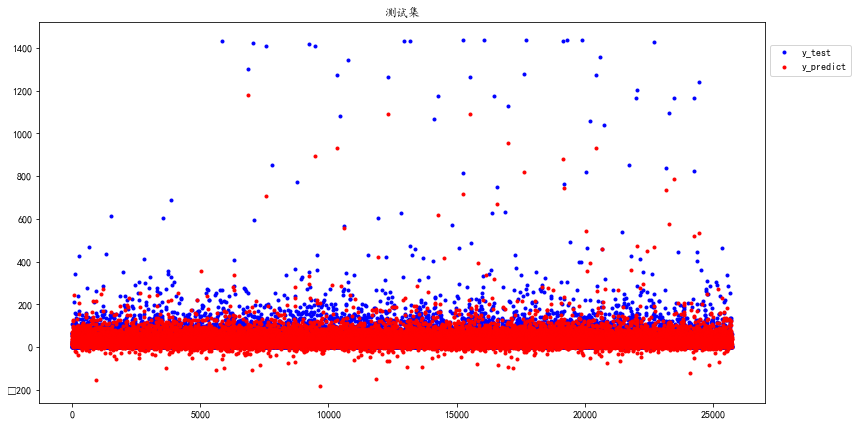

In [14]:
x_data=data[train_col].copy()
y_data=data['候诊/分钟'].copy()
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data,test_size=0.2, random_state=1)##test_size为测试集的占比
_,y_pre=model_fit(x_train, x_test, y_train, y_test)

In [15]:
x_test

,年龄,性别,分诊科室,分诊等级,分诊去向,体温类型,体温,脉搏,收缩压,舒张压,呼吸,SpO2,微量血糖,GCS评分,PHI评分,分诊-月,分诊-日,分诊-时,分诊-分,脉压差,工作日
65291,1.0,NaN,NaN,3,NaN,NaN,37.0,89.96,138.404,81.03,19.3,0.0,0.0,15,0,6,16,23,25,57.374,0
18826,30.0,NaN,NaN,3,NaN,NaN,38.4,89.96,138.404,81.03,19.3,0.0,0.0,15,0,2,16,20,48,57.374,0
20842,26.0,NaN,NaN,4,NaN,NaN,37.0,89.96,138.404,81.03,19.3,0.0,0.0,15,0,2,21,17,43,57.374,0
97367,65.0,NaN,NaN,2,NaN,NaN,36.0,72.00,150.000,100.00,20.0,100.0,0.0,15,0,10,2,20,28,50.000,0
126239,53.0,NaN,NaN,3,NaN,NaN,36.7,66.00,165.000,101.00,19.3,0.0,0.0,15,0,12,22,21,46,64.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4691,10.0,NaN,NaN,4,NaN,NaN,37.0,89.96,138.404,81.03,18.0,99.0,0.0,15,0,1,10,19,24,57.374,1
39322,69.0,NaN,NaN,3,NaN,NaN,36.4,83.00,161.000,87.00,18.0,99.0,0.0,15,0,4,10,19,15,74.000,1
71604,36.0,NaN,NaN,4,NaN,NaN,37.1,89.96,138.404,81.03,18.0,99.0,0.0,15,0,7,3,19,0,57.374,1
16170,6.0,NaN,NaN,3,NaN,NaN,38.6,89.96,138.404,81.03,19.3,0.0,0.0,15,0,2,10,2,17,57.374,0


In [17]:
result=pd.DataFrame()
result['真实值']=y_test
result['预测值']=y_pre

In [19]:
result[((result['预测值']-result['真实值'])<15) & ((result['预测值']-result['真实值'])>0)]

,真实值,预测值
65291,2,14.438783
97367,6,8.093559
105519,14,15.577020
38946,39,39.876486
115359,5,9.391107
...,...,...
15983,2,3.240738
110407,18,24.684905
73157,0,7.461818
16170,1,1.492485


In [20]:
result.to_excel('源数据/test.xlsx')

In [73]:
8445/25729

0.32822884682653813

In [77]:
19197/25729

0.7461230518092425

# 数据处理-20200804

In [17]:
data=data[[ '年龄', '性别', '分诊科室', '分诊等级', '分诊去向', '分诊时间', '到诊时间',
       '体温类型', '体温', '脉搏', '收缩压', '舒张压', '呼吸', 'SpO2', '微量血糖', 'GCS评分',
       'PHI评分', '编码', '分诊', '到诊', '时间差', '分诊-年', '分诊-月',
       '分诊-日', '分诊-时', '分诊-分', '分诊-秒', '候诊/分钟']]
data.head()

,年龄,性别,分诊科室,分诊等级,分诊去向,分诊时间,到诊时间,体温类型,体温,脉搏,收缩压,舒张压,呼吸,SpO2,微量血糖,GCS评分,PHI评分,编码,分诊,到诊,时间差,分诊-年,分诊-月,分诊-日,分诊-时,分诊-分,分诊-秒,候诊/分钟
0,59.0,0,1,2,1,2018-01-01 00:01:00,2018-01-01 01:37:00,1,37.0,51.00,181.000,59.00,19.3,99.0,0.0,15,0,"[60315, 70101, 0, 0]",2018-01-01 00:01:00,2018-01-01 01:37:00,0.066667,2018,1,1,0,1,0,96
1,41.0,0,2,4,1,2018-01-01 00:20:00,2018-01-01 08:15:00,1,37.0,100.00,128.000,85.00,20.0,98.0,0.0,15,0,"[60105, 0, 0, 0]",2018-01-01 00:20:00,2018-01-01 08:15:00,0.329861,2018,1,1,0,20,0,475
2,59.0,1,2,3,1,2018-01-01 00:24:00,2018-01-01 02:42:00,1,36.0,74.00,168.000,85.00,20.0,99.0,0.0,15,0,"[100104, 30303, 100105, 60105]",2018-01-01 00:24:00,2018-01-01 02:42:00,0.095833,2018,1,1,0,24,0,138
3,1.0,1,3,3,1,2018-01-01 00:32:00,2018-01-01 01:41:00,1,38.9,89.96,138.404,81.03,19.3,0.0,0.0,15,0,"[110121, 0, 0, 0]",2018-01-01 00:32:00,2018-01-01 01:41:00,0.047917,2018,1,1,0,32,0,69
4,14.0,0,3,3,1,2018-01-01 00:34:00,2018-01-01 01:44:00,1,39.0,89.96,138.404,81.03,19.3,0.0,0.0,15,0,"[90130, 110121, 0, 0]",2018-01-01 00:34:00,2018-01-01 01:44:00,0.048611,2018,1,1,0,34,0,70


In [18]:

#对性别的处理
male=['男','女']
data['性别']=data['性别'].map(dict(zip(male,range(0,len(male)+1))))

#对分诊科室的处理
fenzhen_department=['急诊外科', '急诊内科', '急诊儿科', '急诊产科', '内科夜诊', '发热门诊', '急诊耳鼻喉科', '急诊复诊',
       '急诊眼科', '急诊妇科', '急诊口腔科', '急诊感染科', '急诊新生儿科']
data['分诊科室']=data['分诊科室'].map(dict(zip(fenzhen_department,range(1,len(fenzhen_department)+1))))

#对分诊去向的处理
fenzhen_whereabouts=['医疗室', '抢救室']
data['分诊去向']=data['分诊去向'].map(dict(zip(fenzhen_whereabouts,range(1,len(fenzhen_whereabouts)+1))))
#对体温类型的处理
type_temperature=['耳温', '腋温']
data['体温类型']=data['体温类型'].map(dict(zip(type_temperature,range(1,len(type_temperature)+1))))

In [19]:
data['脉压差']=data['收缩压']-data['舒张压']

In [20]:
not_needcolumns=[ '分诊时间', '到诊时间','编码', '分诊', '到诊', '时间差', '分诊-年', '分诊-秒', '候诊/分钟']
train_col = [i for i in data.columns if i not in not_needcolumns]
print(train_col)

['年龄', '性别', '分诊科室', '分诊等级', '分诊去向', '体温类型', '体温', '脉搏', '收缩压', '舒张压', '呼吸', 'SpO2', '微量血糖', 'GCS评分', 'PHI评分', '分诊-月', '分诊-日', '分诊-时', '分诊-分', '脉压差']


In [21]:
x_data=data[train_col].copy()
y_data=data['候诊/分钟'].copy()
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data,test_size=0.2, random_state=1)##test_size为测试集的占比


In [22]:
gbm = lgb.LGBMRegressor(n_estimators=2000,num_leaves=90,max_depth=13,early_stopping_round=50,metric=['l1'])
gbm.fit(x_train,y_train,eval_set=[(x_train,y_train),(x_test,y_test)],eval_metric='l1')

F:\Anaconda\lib\site-packages\lightgbm\engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's l1: 30.0821	valid_1's l1: 30.3088
Training until validation scores don't improve for 50 rounds.
[2]	training's l1: 29.5477	valid_1's l1: 29.8154
[3]	training's l1: 29.0673	valid_1's l1: 29.3668
[4]	training's l1: 28.6787	valid_1's l1: 29.0064
[5]	training's l1: 28.2894	valid_1's l1: 28.6499
[6]	training's l1: 27.9806	valid_1's l1: 28.3769
[7]	training's l1: 27.7167	valid_1's l1: 28.1375
[8]	training's l1: 27.477	valid_1's l1: 27.9221
[9]	training's l1: 27.2552	valid_1's l1: 27.7152
[10]	training's l1: 27.0516	valid_1's l1: 27.5238
[11]	training's l1: 26.8722	valid_1's l1: 27.3684
[12]	training's l1: 26.709	valid_1's l1: 27.2292
[13]	training's l1: 26.5814	valid_1's l1: 27.1447
[14]	training's l1: 26.448	valid_1's l1: 27.0243
[15]	training's l1: 26.3333	valid_1's l1: 26.9512
[16]	training's l1: 26.221	valid_1's l1: 26.862
[17]	training's l1: 26.1072	valid_1's l1: 26.7793
[18]	training's l1: 26.0075	valid_1's l1: 26.6933
[19]	training's l1: 25.9151	valid_1's l1: 26.6367
[2

[189]	training's l1: 22.8348	valid_1's l1: 25.7071
[190]	training's l1: 22.8323	valid_1's l1: 25.7094
[191]	training's l1: 22.8242	valid_1's l1: 25.7058
[192]	training's l1: 22.8119	valid_1's l1: 25.7049
[193]	training's l1: 22.8015	valid_1's l1: 25.7037
[194]	training's l1: 22.7896	valid_1's l1: 25.7017
[195]	training's l1: 22.7879	valid_1's l1: 25.701
[196]	training's l1: 22.7809	valid_1's l1: 25.7019
[197]	training's l1: 22.7715	valid_1's l1: 25.7016
[198]	training's l1: 22.745	valid_1's l1: 25.6844
[199]	training's l1: 22.7362	valid_1's l1: 25.6839
[200]	training's l1: 22.7274	valid_1's l1: 25.6876
[201]	training's l1: 22.7188	valid_1's l1: 25.688
[202]	training's l1: 22.7114	valid_1's l1: 25.6876
[203]	training's l1: 22.7043	valid_1's l1: 25.6856
[204]	training's l1: 22.6997	valid_1's l1: 25.6856
[205]	training's l1: 22.6919	valid_1's l1: 25.6867
[206]	training's l1: 22.6802	valid_1's l1: 25.6867
[207]	training's l1: 22.6626	valid_1's l1: 25.6772
[208]	training's l1: 22.6531	valid

[387]	training's l1: 21.0674	valid_1's l1: 25.4345
[388]	training's l1: 21.0541	valid_1's l1: 25.4262
[389]	training's l1: 21.0389	valid_1's l1: 25.4247
[390]	training's l1: 21.0314	valid_1's l1: 25.4231
[391]	training's l1: 21.0238	valid_1's l1: 25.4209
[392]	training's l1: 21.0147	valid_1's l1: 25.4164
[393]	training's l1: 21.009	valid_1's l1: 25.4187
[394]	training's l1: 21.0013	valid_1's l1: 25.4195
[395]	training's l1: 20.996	valid_1's l1: 25.4203
[396]	training's l1: 20.986	valid_1's l1: 25.4192
[397]	training's l1: 20.9811	valid_1's l1: 25.4209
[398]	training's l1: 20.9718	valid_1's l1: 25.42
[399]	training's l1: 20.9638	valid_1's l1: 25.42
[400]	training's l1: 20.9573	valid_1's l1: 25.419
[401]	training's l1: 20.9516	valid_1's l1: 25.4179
[402]	training's l1: 20.9438	valid_1's l1: 25.4175
[403]	training's l1: 20.9415	valid_1's l1: 25.4179
[404]	training's l1: 20.9367	valid_1's l1: 25.4201
[405]	training's l1: 20.9306	valid_1's l1: 25.4184
[406]	training's l1: 20.9229	valid_1's 

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              early_stopping_round=50, importance_type='split',
              learning_rate=0.1, max_depth=13, metric=['l1'],
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=2000, n_jobs=-1, num_leaves=90, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

平均绝对误差: 25.397744398278462
均方根误差： 2976.431973055818
R方决定系数： 0.30117788790545863
校正决定系数(Adjusted R-Square）： 0.30063422670109063


F:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
F:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


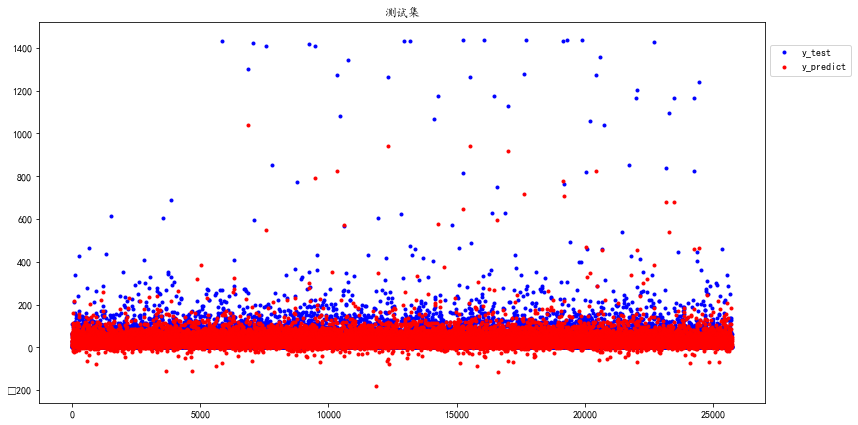

In [23]:
y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration_)

print('================================================')
print('平均绝对误差:', mean_absolute_error(y_test, y_pred))

print('均方根误差：', mean_squared_error(y_test,y_pred))

print('R方决定系数：' , r2_score(y_test,y_pred)  )
##决定系数：R2（R-Square）
##一般来说，R-Squared 越大，表示模型拟合效果越好。R-Squared 反映的是大概有多准，
##因为，随着样本数量的增加，R-Square必然增加，无法真正定量说明准确程度，只能大概定量。

#     校正决定系数（Adjusted R-Square）=1-(1-r^2)*(n-1)/(n-p-1) 其中，n 是(测试集)样本数量，p 是特征数量。
print('校正决定系数(Adjusted R-Square）：' , 1-((1-r2_score(y_test,y_pred))*(len(y_test)-1))/(len(x_test)-len(x_test.columns)-1) )
print('===================================================')

plt.figure(figsize=(13,7))

plt.plot(np.array(y_test),'b.',label='y_test')
plt.plot(np.array(y_pred),'r.',label='y_predict')

plt.title('测试集')
plt.legend(loc='center', bbox_to_anchor=(1.063,0.9),ncol=1) # 显示图例
plt.show()

# 数据处理-20200731

In [24]:
data.columns

Index(['年龄', '性别', '分诊科室', '分诊等级', '分诊去向', '分诊时间', '到诊时间', '体温类型', '体温', '脉搏',
       '收缩压', '舒张压', '呼吸', 'SpO2', '微量血糖', 'GCS评分', 'PHI评分', '编码', '分诊', '到诊',
       '时间差', '分诊-年', '分诊-月', '分诊-日', '分诊-时', '分诊-分', '分诊-秒', '候诊/分钟', '脉压差'],
      dtype='object')

In [25]:
##首先，把一些特征去除：'现病史', '既病史', '药物过敏史', '诊断', '处理意见', '注意事项','时长', '没有时长的主诉', '时长（统一数字）_1'
# '来诊主诉', '主诉','就诊时间', '抢救上床时间', '疼痛评分'


In [26]:
data=data[[ '年龄', '性别', '分诊科室', '分诊等级', '分诊去向', '分诊时间', '到诊时间',
       '体温类型', '体温', '脉搏', '收缩压', '舒张压', '呼吸', 'SpO2', '微量血糖', 'GCS评分',
       'PHI评分', '编码', '分诊', '到诊', '时间差', '分诊-年', '分诊-月',
       '分诊-日', '分诊-时', '分诊-分', '分诊-秒', '候诊/分钟']]
data.head()

,年龄,性别,分诊科室,分诊等级,分诊去向,分诊时间,到诊时间,体温类型,体温,脉搏,收缩压,舒张压,呼吸,SpO2,微量血糖,GCS评分,PHI评分,编码,分诊,到诊,时间差,分诊-年,分诊-月,分诊-日,分诊-时,分诊-分,分诊-秒,候诊/分钟
0,59.0,NaN,NaN,2,NaN,2018-01-01 00:01:00,2018-01-01 01:37:00,NaN,37.0,51.00,181.000,59.00,19.3,99.0,0.0,15,0,"[60315, 70101, 0, 0]",2018-01-01 00:01:00,2018-01-01 01:37:00,0.066667,2018,1,1,0,1,0,96
1,41.0,NaN,NaN,4,NaN,2018-01-01 00:20:00,2018-01-01 08:15:00,NaN,37.0,100.00,128.000,85.00,20.0,98.0,0.0,15,0,"[60105, 0, 0, 0]",2018-01-01 00:20:00,2018-01-01 08:15:00,0.329861,2018,1,1,0,20,0,475
2,59.0,NaN,NaN,3,NaN,2018-01-01 00:24:00,2018-01-01 02:42:00,NaN,36.0,74.00,168.000,85.00,20.0,99.0,0.0,15,0,"[100104, 30303, 100105, 60105]",2018-01-01 00:24:00,2018-01-01 02:42:00,0.095833,2018,1,1,0,24,0,138
3,1.0,NaN,NaN,3,NaN,2018-01-01 00:32:00,2018-01-01 01:41:00,NaN,38.9,89.96,138.404,81.03,19.3,0.0,0.0,15,0,"[110121, 0, 0, 0]",2018-01-01 00:32:00,2018-01-01 01:41:00,0.047917,2018,1,1,0,32,0,69
4,14.0,NaN,NaN,3,NaN,2018-01-01 00:34:00,2018-01-01 01:44:00,NaN,39.0,89.96,138.404,81.03,19.3,0.0,0.0,15,0,"[90130, 110121, 0, 0]",2018-01-01 00:34:00,2018-01-01 01:44:00,0.048611,2018,1,1,0,34,0,70


In [27]:

#对性别的处理
male=['男','女']
data['性别']=data['性别'].map(dict(zip(male,range(0,len(male)+1))))

#对分诊科室的处理
fenzhen_department=['急诊外科', '急诊内科', '急诊儿科', '急诊产科', '内科夜诊', '发热门诊', '急诊耳鼻喉科', '急诊复诊',
       '急诊眼科', '急诊妇科', '急诊口腔科', '急诊感染科', '急诊新生儿科']
data['分诊科室']=data['分诊科室'].map(dict(zip(fenzhen_department,range(1,len(fenzhen_department)+1))))

#对分诊去向的处理
fenzhen_whereabouts=['医疗室', '抢救室']
data['分诊去向']=data['分诊去向'].map(dict(zip(fenzhen_whereabouts,range(1,len(fenzhen_whereabouts)+1))))
#对体温类型的处理
type_temperature=['耳温', '腋温']
data['体温类型']=data['体温类型'].map(dict(zip(type_temperature,range(1,len(type_temperature)+1))))

# lightGBM模型-20200731

In [28]:
from sklearn.model_selection import cross_val_predict, RandomizedSearchCV ##对数据集进行指定次数的交叉验证并为每次验证效果评测
import lightgbm as lgb ##lightGBM模型
from lightgbm import LGBMRegressor
from sklearn.model_selection import StratifiedKFold, KFold ##交叉验证
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score  #平方绝对误差，均方误差， #R square
from sklearn.model_selection import train_test_split 
import joblib
import math
from sklearn.model_selection import cross_val_score

In [29]:
data.columns

Index(['年龄', '性别', '分诊科室', '分诊等级', '分诊去向', '分诊时间', '到诊时间', '体温类型', '体温', '脉搏',
       '收缩压', '舒张压', '呼吸', 'SpO2', '微量血糖', 'GCS评分', 'PHI评分', '编码', '分诊', '到诊',
       '时间差', '分诊-年', '分诊-月', '分诊-日', '分诊-时', '分诊-分', '分诊-秒', '候诊/分钟'],
      dtype='object')

In [30]:
not_needcolumns=[ '分诊时间', '到诊时间','编码', '分诊', '到诊', '时间差', '分诊-年', '分诊-秒', '候诊/分钟']
train_col = [i for i in data.columns if i not in not_needcolumns]
print(train_col)

['年龄', '性别', '分诊科室', '分诊等级', '分诊去向', '体温类型', '体温', '脉搏', '收缩压', '舒张压', '呼吸', 'SpO2', '微量血糖', 'GCS评分', 'PHI评分', '分诊-月', '分诊-日', '分诊-时', '分诊-分']


In [31]:
x_data=data[train_col].copy()
y_data=data['候诊/分钟'].copy()
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data,test_size=0.2, random_state=1)##test_size为测试集的占比


In [32]:
gbm = lgb.LGBMRegressor(n_estimators=2000,num_leaves=90,max_depth=13,early_stopping_round=50,metric=['l1'])
gbm.fit(x_train,y_train,eval_set=[(x_train,y_train),(x_test,y_test)],eval_metric='l1')

[1]	training's l1: 30.0791	valid_1's l1: 30.3118

F:\Anaconda\lib\site-packages\lightgbm\engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 50 rounds.
[2]	training's l1: 29.5421	valid_1's l1: 29.818
[3]	training's l1: 29.074	valid_1's l1: 29.3919
[4]	training's l1: 28.6645	valid_1's l1: 28.9937
[5]	training's l1: 28.2956	valid_1's l1: 28.6469
[6]	training's l1: 27.9874	valid_1's l1: 28.3747
[7]	training's l1: 27.7134	valid_1's l1: 28.1297
[8]	training's l1: 27.4615	valid_1's l1: 27.9037
[9]	training's l1: 27.2386	valid_1's l1: 27.704
[10]	training's l1: 27.044	valid_1's l1: 27.5244
[11]	training's l1: 26.8627	valid_1's l1: 27.3512
[12]	training's l1: 26.7178	valid_1's l1: 27.2395
[13]	training's l1: 26.5772	valid_1's l1: 27.117
[14]	training's l1: 26.4449	valid_1's l1: 27.0084
[15]	training's l1: 26.3397	valid_1's l1: 26.9228
[16]	training's l1: 26.2214	valid_1's l1: 26.8259
[17]	training's l1: 26.12	valid_1's l1: 26.7431
[18]	training's l1: 26.0339	valid_1's l1: 26.674
[19]	training's l1: 25.9417	valid_1's l1: 26.5971
[20]	training's l1: 25.8677	valid_1's l1: 26.5359
[21

[173]	training's l1: 23.099	valid_1's l1: 25.5704
[174]	training's l1: 23.0871	valid_1's l1: 25.574
[175]	training's l1: 23.0784	valid_1's l1: 25.5772
[176]	training's l1: 23.0643	valid_1's l1: 25.5692
[177]	training's l1: 23.0477	valid_1's l1: 25.5669
[178]	training's l1: 23.0362	valid_1's l1: 25.5679
[179]	training's l1: 23.0243	valid_1's l1: 25.5712
[180]	training's l1: 23.0017	valid_1's l1: 25.5555
[181]	training's l1: 22.9944	valid_1's l1: 25.5591
[182]	training's l1: 22.9879	valid_1's l1: 25.56
[183]	training's l1: 22.9844	valid_1's l1: 25.5579
[184]	training's l1: 22.9495	valid_1's l1: 25.5327
[185]	training's l1: 22.9394	valid_1's l1: 25.5294
[186]	training's l1: 22.9206	valid_1's l1: 25.5211
[187]	training's l1: 22.9146	valid_1's l1: 25.5242
[188]	training's l1: 22.9052	valid_1's l1: 25.5232
[189]	training's l1: 22.8945	valid_1's l1: 25.5229
[190]	training's l1: 22.8865	valid_1's l1: 25.5235
[191]	training's l1: 22.8815	valid_1's l1: 25.5241
[192]	training's l1: 22.8727	valid_

[346]	training's l1: 21.5401	valid_1's l1: 25.3743
[347]	training's l1: 21.5242	valid_1's l1: 25.3623
[348]	training's l1: 21.5172	valid_1's l1: 25.3634
[349]	training's l1: 21.5116	valid_1's l1: 25.3631
[350]	training's l1: 21.5054	valid_1's l1: 25.3647
[351]	training's l1: 21.4971	valid_1's l1: 25.3629
[352]	training's l1: 21.4885	valid_1's l1: 25.3708
[353]	training's l1: 21.4811	valid_1's l1: 25.3725
[354]	training's l1: 21.4468	valid_1's l1: 25.3459
[355]	training's l1: 21.4434	valid_1's l1: 25.3456
[356]	training's l1: 21.4303	valid_1's l1: 25.3394
[357]	training's l1: 21.4241	valid_1's l1: 25.3388
[358]	training's l1: 21.4167	valid_1's l1: 25.3426
[359]	training's l1: 21.4104	valid_1's l1: 25.344
[360]	training's l1: 21.3925	valid_1's l1: 25.3285
[361]	training's l1: 21.3868	valid_1's l1: 25.328
[362]	training's l1: 21.3771	valid_1's l1: 25.3255
[363]	training's l1: 21.3692	valid_1's l1: 25.3244
[364]	training's l1: 21.3638	valid_1's l1: 25.3256
[365]	training's l1: 21.3518	vali

[534]	training's l1: 20.1129	valid_1's l1: 25.1968
[535]	training's l1: 20.108	valid_1's l1: 25.1984
[536]	training's l1: 20.101	valid_1's l1: 25.1994
[537]	training's l1: 20.0937	valid_1's l1: 25.1997
[538]	training's l1: 20.0882	valid_1's l1: 25.2016
[539]	training's l1: 20.0837	valid_1's l1: 25.2006
[540]	training's l1: 20.0793	valid_1's l1: 25.1999
[541]	training's l1: 20.0706	valid_1's l1: 25.2005
[542]	training's l1: 20.0625	valid_1's l1: 25.1982
[543]	training's l1: 20.0568	valid_1's l1: 25.2011
[544]	training's l1: 20.0524	valid_1's l1: 25.2026
[545]	training's l1: 20.0472	valid_1's l1: 25.202
[546]	training's l1: 20.0326	valid_1's l1: 25.1973
[547]	training's l1: 20.0282	valid_1's l1: 25.2006
[548]	training's l1: 20.0245	valid_1's l1: 25.2013
[549]	training's l1: 20.0192	valid_1's l1: 25.2015
[550]	training's l1: 20.013	valid_1's l1: 25.2012
[551]	training's l1: 20.008	valid_1's l1: 25.2023
[552]	training's l1: 20.0014	valid_1's l1: 25.2039
[553]	training's l1: 19.9988	valid_1

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              early_stopping_round=50, importance_type='split',
              learning_rate=0.1, max_depth=13, metric=['l1'],
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=2000, n_jobs=-1, num_leaves=90, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

平均绝对误差: 25.17254279529918
均方根误差： 2881.908159009535
R方决定系数： 0.32337067845905487
校正决定系数(Adjusted R-Square）： 0.32287062178204384


F:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
F:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


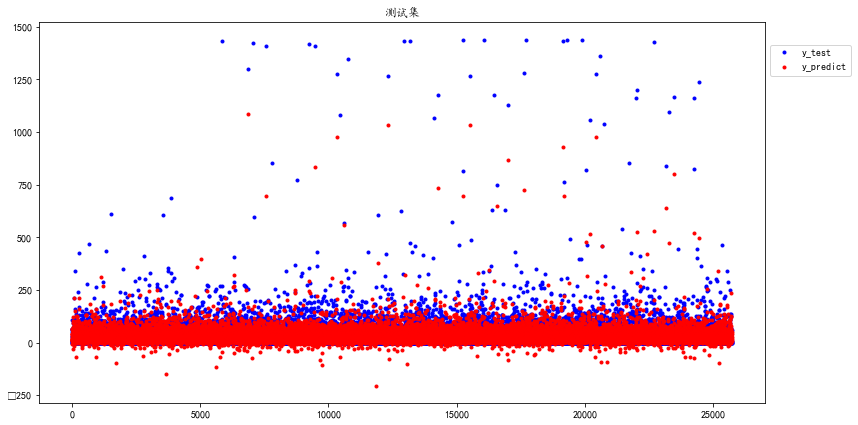

In [33]:
y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration_)

print('================================================')
print('平均绝对误差:', mean_absolute_error(y_test, y_pred))

print('均方根误差：', mean_squared_error(y_test,y_pred))

print('R方决定系数：' , r2_score(y_test,y_pred)  )
##决定系数：R2（R-Square）
##一般来说，R-Squared 越大，表示模型拟合效果越好。R-Squared 反映的是大概有多准，
##因为，随着样本数量的增加，R-Square必然增加，无法真正定量说明准确程度，只能大概定量。

#     校正决定系数（Adjusted R-Square）=1-(1-r^2)*(n-1)/(n-p-1) 其中，n 是(测试集)样本数量，p 是特征数量。
print('校正决定系数(Adjusted R-Square）：' , 1-((1-r2_score(y_test,y_pred))*(len(y_test)-1))/(len(x_test)-len(x_test.columns)-1) )
print('===================================================')

plt.figure(figsize=(13,7))

plt.plot(np.array(y_test),'b.',label='y_test')
plt.plot(np.array(y_pred),'r.',label='y_predict')

plt.title('测试集')
plt.legend(loc='center', bbox_to_anchor=(1.063,0.9),ncol=1) # 显示图例
plt.show()

In [1]:
import requests
import pandas as pd

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 5.1) AppleWebKit/535.11 (KHTML, like Gecko) Chrome/17.0.963.84 Safari/535.11 SE 2.X MetaSr 1.0'}
reponse = requests.get("https://read.douban.com/category?kind=114", headers=header)



In [ ]:
info_list = reponse.
print(info_list)